In [ ]:

#Step 1: Data Preprocessing
import pandas as pd
import numpy as np
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix

# Load the dataset
dataset = pd.read_csv('Household-population-India.csv')
print(dataset.head())

# Drop rows with missing values
dataset = dataset.dropna()

# Columns to keep
columns_to_keep = ['State  Code', 'District Code', 'Sub District Code',
                  'India/ State/ Union Territory/ District/ Sub-district', 'Name',
                  'Total/\nRural/\nUrban', 'Inhabited villages ', 'Uninhabited villages',
                  'Number of towns', 'Number of households', 'PersonPopulation',
                  'Male Population', 'Female Population', 'Area\n (In sq. km)',
                  'Population per sq. km.']

# Keep only the specified columns
dataset_cleaned = dataset[columns_to_keep]
print(dataset_cleaned.head())

# Create true labels based on a threshold (for evaluation purposes)
threshold = np.percentile(dataset_cleaned['PersonPopulation'], 75)
dataset_cleaned['PersonPopulation_Annotated'] = (dataset_cleaned['PersonPopulation'] > threshold).astype(int)

# Save the cleaned dataset
dataset_cleaned.to_csv('cleaned_data.csv', index=False)

# The true labels will be used for comparison in later steps
true_labels = dataset_cleaned['PersonPopulation_Annotated']

# Initial metrics (should be perfect as we haven't modified the data)
predicted_labels = true_labels
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
accuracy = accuracy_score(true_labels, predicted_labels)
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("Step 1 Evaluation Metrics:")
print("Precision:", precision)
print("Recall:", recall)
print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)


   State  Code District Code Sub District Code  \
0          0.0             0                 0   
1          0.0             0                 0   
2          0.0             0                 0   
3          1.0             0                 0   
4          1.0             0                 0   

  India/ State/ Union Territory/ District/ Sub-district                Name  \
0                                              INDIA               INDIA @&   
1                                              INDIA                INDIA $   
2                                              INDIA                INDIA $   
3                                              STATE     JAMMU & KASHMIR @&   
4                                              STATE        JAMMU & KASHMIR   

  Total/\nRural/\nUrban Inhabited villages  Uninhabited villages  \
0                 Total                 NaN               43,324   
1                 Rural              36,285               43,324   
2                 Ur

In [ ]:
# Step 2: Adding Noise with Differential Privacy
import pandas as pd
import numpy as np
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix

# Load the cleaned dataset
dataset_cleaned = pd.read_csv('cleaned_data.csv')

# Parameters for Differential Privacy
epsilon = 1.0  # Privacy parameter
numerical_attribute_of_interest = 'PersonPopulation'

# Function to calculate sensitivity of the numerical attribute
def sensitivity_mean(attribute_name, df):
    def attribute_mean(df):
        return np.mean(df[attribute_name])

    df_str = df.copy()
    df_str[attribute_name] = df_str[attribute_name] + 0.7
    return np.max(np.abs(attribute_mean(df_str) - attribute_mean(df)))

# Calculate sensitivity
sensitivity_person = sensitivity_mean(numerical_attribute_of_interest, dataset_cleaned)
print(f"Sensitivity of {numerical_attribute_of_interest}: {sensitivity_person}")

# Function to add noise with Differential Privacy
def add_noise(data, epsilon, sensitivity):
    scale = sensitivity / epsilon
    noise = np.random.normal(loc=0.0, scale=scale, size=len(data))
    return data + noise

# Add noise to 'PersonPopulation' column
dataset_cleaned['PersonPopulation_Noisy'] = add_noise(dataset_cleaned['PersonPopulation'], epsilon, sensitivity_person)

# Annotate data after adding noise
threshold = np.percentile(dataset_cleaned['PersonPopulation'], 75)
dataset_cleaned['PersonPopulation_Noisy_Annotated'] = (dataset_cleaned['PersonPopulation_Noisy'] > threshold).astype(int)

# Calculate precision, recall, accuracy, and confusion matrix
true_labels = dataset_cleaned['PersonPopulation_Annotated']
predicted_labels = dataset_cleaned['PersonPopulation_Noisy_Annotated']

precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
accuracy = accuracy_score(true_labels, predicted_labels)
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("Step 2 Evaluation Metrics:")
print("Precision:", precision)
print("Recall:", recall)
print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)

# Save the dataset with noise
dataset_cleaned.to_csv('data_with_noise.csv', index=False)


Sensitivity of PersonPopulation: 0.7000000000698492
Step 2 Evaluation Metrics:
Precision: 0.999798752264037
Recall: 1.0
Accuracy: 0.9999496830029184
Confusion Matrix:
 [[14905     1]
 [    0  4968]]


In [ ]:
# Step 3: Homomorphic Encryption
import pandas as pd
import numpy as np
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix

# Load the dataset with noise
dataset_cleaned = pd.read_csv('data_with_noise.csv')

# Homomorphic encryption functions
def homomorphic_encrypt(value, public_key):
    encrypted_value = value + public_key
    return encrypted_value

def homomorphic_decrypt(encrypted_value, private_key):
    decrypted_value = encrypted_value - private_key
    return decrypted_value

# Encryption parameters
public_key = 100
private_key = 100

# Apply homomorphic encryption to 'PersonPopulation_Noisy' column
dataset_cleaned['PersonPopulation_Encrypted'] = dataset_cleaned['PersonPopulation_Noisy'].apply(lambda x: homomorphic_encrypt(x, public_key))

# For metrics calculation, decrypt and annotate again
dataset_cleaned['PersonPopulation_Decrypted'] = dataset_cleaned['PersonPopulation_Encrypted'].apply(lambda x: homomorphic_decrypt(x, private_key))
dataset_cleaned['PersonPopulation_Decrypted_Annotated'] = (dataset_cleaned['PersonPopulation_Decrypted'] > threshold).astype(int)

# Calculate precision, recall, accuracy, and confusion matrix
true_labels = dataset_cleaned['PersonPopulation_Annotated']
predicted_labels = dataset_cleaned['PersonPopulation_Decrypted_Annotated']

precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
accuracy = accuracy_score(true_labels, predicted_labels)
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("Step 3 Evaluation Metrics:")
print("Precision:", precision)
print("Recall:", recall)
print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)

# Save the encrypted dataset
dataset_cleaned.to_csv('data_with_encryption.csv', index=False)


Step 3 Evaluation Metrics:
Precision: 0.999798752264037
Recall: 1.0
Accuracy: 0.9999496830029184
Confusion Matrix:
 [[14905     1]
 [    0  4968]]


<ipython-input-14-9611b40d4bca>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  column_data.dropna(inplace=True)


Epoch 1/10
235/235 [==============================] - 2s 3ms/step - loss: 0.0420 - val_loss: 5.5775e-04
Epoch 2/10
235/235 [==============================] - 1s 2ms/step - loss: 1.2216e-05 - val_loss: 5.3798e-04
Epoch 3/10
235/235 [==============================] - 1s 3ms/step - loss: 6.9367e-06 - val_loss: 5.3769e-04
Epoch 4/10
235/235 [==============================] - 1s 3ms/step - loss: 6.8159e-06 - val_loss: 5.3765e-04
Epoch 5/10
235/235 [==============================] - 1s 2ms/step - loss: 6.7922e-06 - val_loss: 5.3764e-04
Epoch 6/10
235/235 [==============================] - 1s 2ms/step - loss: 6.7851e-06 - val_loss: 5.3764e-04
Epoch 7/10
235/235 [==============================] - 1s 3ms/step - loss: 6.7826e-06 - val_loss: 5.3764e-04
Epoch 8/10
235/235 [==============================] - 1s 3ms/step - loss: 6.7816e-06 - val_loss: 5.3764e-04
Epoch 9/10
235/235 [==============================] - 1s 3ms/step - loss: 6.7810e-06 - val_loss: 5.3764e-04
Epoch 10/10
59/59 [=============

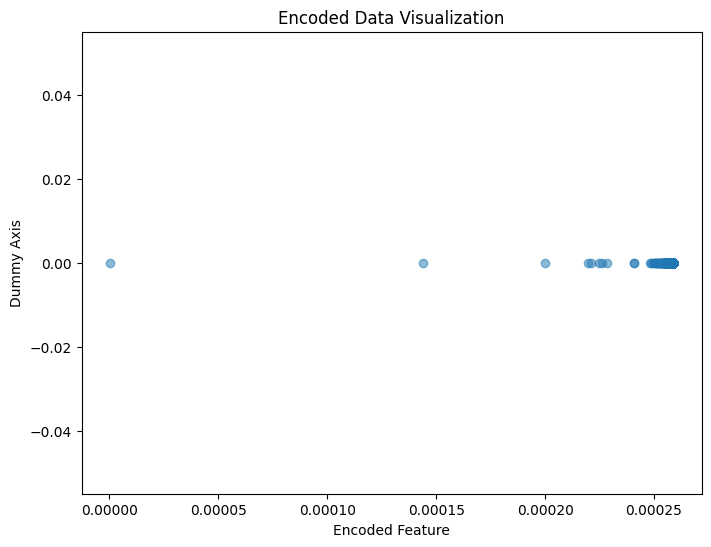

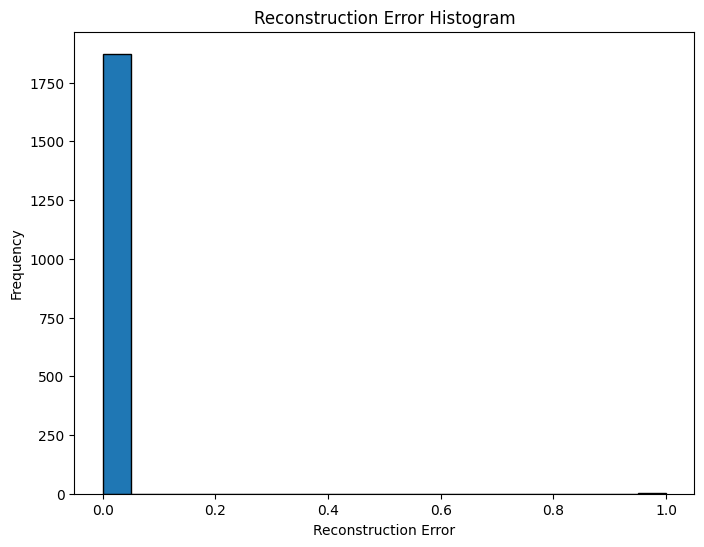

Step 4 Evaluation Metrics:
Accuracy: 0.9994663820704376
Precision: 0.0
Recall: 0.0
Confusion Matrix:
 [[1873    1]
 [   0    0]]


In [ ]:
# Step 4: Autoencoder Training and Evaluation
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix

# Load the data from output.csv
data = pd.read_csv('output.csv')

# Extract the column of interest
column_of_interest = 'Area\n (In sq. km)'
column_data = data[[column_of_interest]]

# Drop any rows with missing values in the column of interest
column_data.dropna(inplace=True)

# Convert the column data to numpy array
column_data_array = column_data.to_numpy()

# Normalize the data
scaler = MinMaxScaler()
column_data_scaled = scaler.fit_transform(column_data_array)

# Split the data into train and test sets
train_data, test_data = train_test_split(column_data_scaled, test_size=0.2, random_state=42)

# Define the input shape
input_shape = train_data.shape[1]

# Define the autoencoder architecture - ReLu
input_layer = Input(shape=(input_shape,))
encoded = Dense(64, activation='relu')(input_layer)
encoded = Dense(32, activation='relu')(encoded)
encoded = Dense(16, activation='relu')(encoded)

decoded = Dense(32, activation='relu')(encoded)
decoded = Dense(64, activation='relu')(decoded)
decoded = Dense(input_shape, activation='sigmoid')(decoded)

# Compile the autoencoder model
autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Train the autoencoder model
autoencoder.fit(train_data, train_data, epochs=10, batch_size=32, validation_data=(test_data, test_data))

# Evaluate the performance of the trained model
evaluation_loss = autoencoder.evaluate(test_data, test_data)
print("Evaluation Loss:", evaluation_loss)

# Use the trained autoencoder to encode and decode the data
encoded_data = autoencoder.predict(test_data)

# Visualize Encoded Data
plt.figure(figsize=(8, 6))
plt.scatter(encoded_data, np.zeros_like(encoded_data), alpha=0.5)
plt.title("Encoded Data Visualization")
plt.xlabel("Encoded Feature")
plt.ylabel("Dummy Axis")
plt.show()

# Reconstruction Error Analysis
reconstruction_errors = np.mean(np.square(test_data - encoded_data), axis=1)
plt.figure(figsize=(8, 6))
plt.hist(reconstruction_errors, bins=20, edgecolor='black')
plt.title("Reconstruction Error Histogram")
plt.xlabel("Reconstruction Error")
plt.ylabel("Frequency")
plt.show()

# Define a threshold to classify anomalies (e.g., using mean + 2 * standard deviation)
threshold = np.mean(reconstruction_errors) + 2 * np.std(reconstruction_errors)

# Classify data points as normal or anomalous based on the adjusted threshold
predicted_labels = (reconstruction_errors > threshold).astype(int)

# Placeholder for true labels (all zeros)
true_labels = np.zeros_like(predicted_labels)

accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, zero_division=0)
recall = recall_score(true_labels, predicted_labels, zero_division=0)
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("Step 4 Evaluation Metrics:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("Confusion Matrix:\n", conf_matrix)


In [ ]:
# Step 5: Evaluation with Homomorphic Encryption and Autoencoder
import pandas as pd
import numpy as np
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix

# Load the dataset with encryption and autoencoder results
dataset_cleaned = pd.read_csv('data_with_encryption.csv')

# Assuming autoencoder was applied to some attribute, here PersonPopulation for consistency
autoencoder_predicted = dataset_cleaned['PersonPopulation_Decrypted'].values
original_values = dataset_cleaned['PersonPopulation'].values

# Simulate some noise for evaluation
dataset_cleaned['PersonPopulation_Autoencoder_Noisy'] = add_noise(autoencoder_predicted, epsilon, sensitivity_person)
dataset_cleaned['PersonPopulation_Autoencoder_Annotated'] = (dataset_cleaned['PersonPopulation_Autoencoder_Noisy'] > threshold).astype(int)

# Calculate precision, recall, accuracy, and confusion matrix
true_labels = dataset_cleaned['PersonPopulation_Annotated']
predicted_labels = dataset_cleaned['PersonPopulation_Autoencoder_Annotated']

precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
accuracy = accuracy_score(true_labels, predicted_labels)
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("Step 5 Evaluation Metrics:")
print("Precision:", precision)
print("Recall:", recall)
print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)

# Save the final dataset with all modifications
dataset_cleaned.to_csv('final_data_with_evaluation.csv', index=False)


Step 5 Evaluation Metrics:
Precision: 0.2702055912107038
Recall: 1.0
Accuracy: 0.32484653315890105
Confusion Matrix:
 [[ 1488 13418]
 [    0  4968]]
